## Modeling scATAC-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import seaborn

In [4]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import pandas as pd
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [6]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [7]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [8]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [9]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# device = 'cpu'

Using device: cuda:0


In [10]:
import scanpy as sc

In [11]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')
rna.shape, atac.shape

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


((16918, 14663), (16918, 228259))

In [12]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


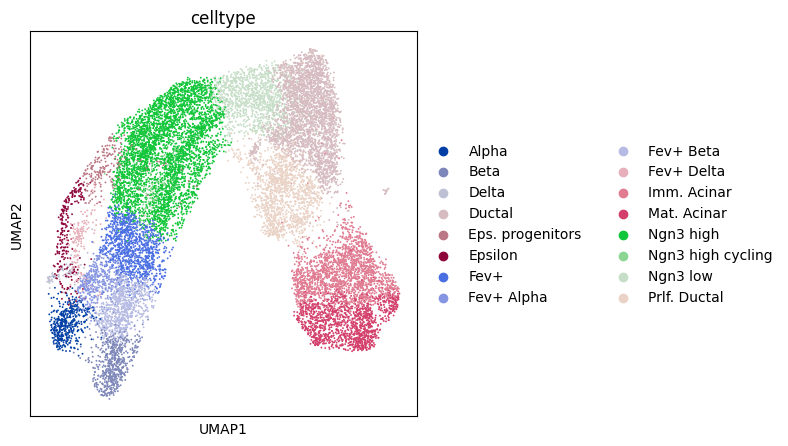

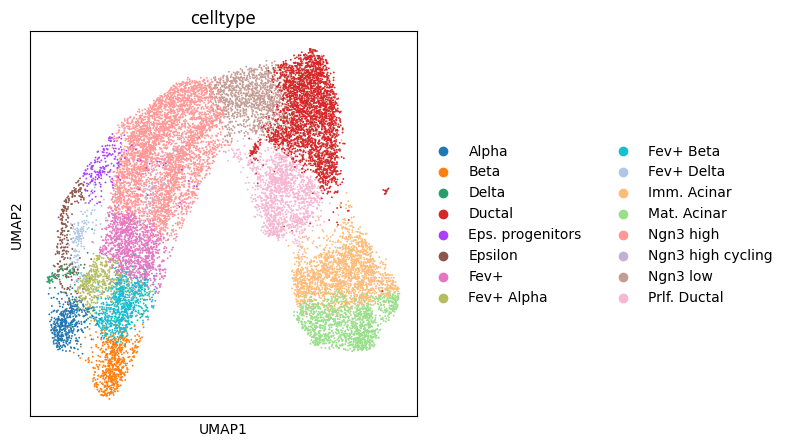

In [13]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='celltype')

#ATAC
sc.pl.umap(atac, color='celltype')

In [14]:
atac.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

In [15]:
# to match the barcode IDs, use the prefix from RNA to match ATAC (anchor = 10 first nucleotides)
assert np.all(rna.obs_names.str[:10] == atac.obs_names.str[:10])
rna.obs_names = atac.obs_names
rna.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

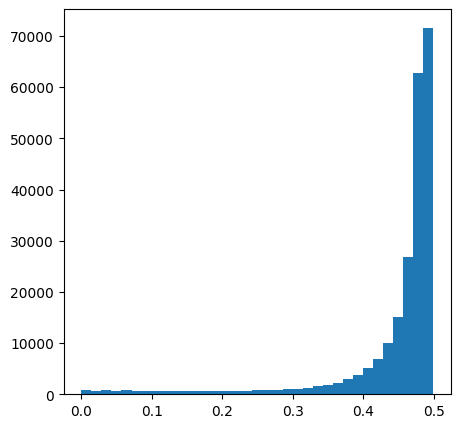

In [16]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [17]:
atac.shape

(16918, 228259)

In [18]:
print('here...')

here...


In [ ]:
n_select = 6000
n_sample_cells = n_select
# n_sample_peaks = 250
n_sample_peaks = int(n_sample_cells * 1.2)

n_cell_types = len(set(atac.obs['celltype']))

obs_sample = atac.obs.groupby('celltype').sample(int(n_sample_cells / n_cell_types), random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(4148, 7200)

In [20]:
ad.obs['celltype'].value_counts()

celltype
Ngn3 high            358
Ductal               350
Imm. Acinar          338
Prlf. Ductal         333
Mat. Acinar          327
Fev+                 318
Ngn3 low             312
Fev+ Beta            293
Beta                 276
Fev+ Alpha           260
Alpha                253
Epsilon              201
Eps. progenitors     173
Fev+ Delta           150
Ngn3 high cycling    130
Delta                 76
Name: count, dtype: int64

In [21]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [22]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(4148, 4148)

In [23]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

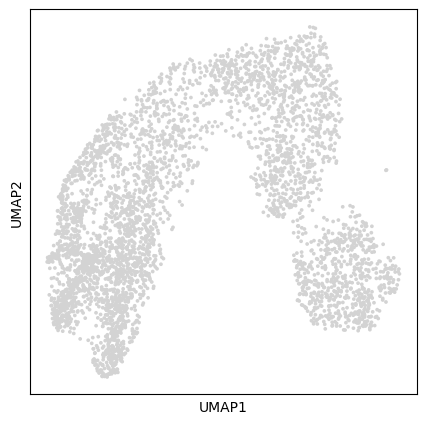

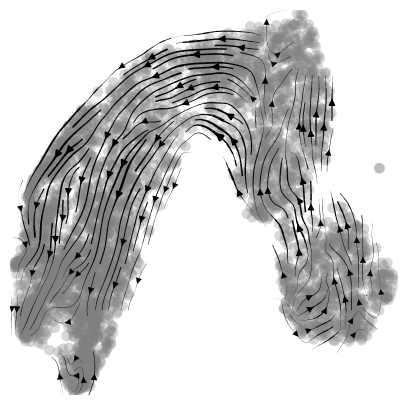

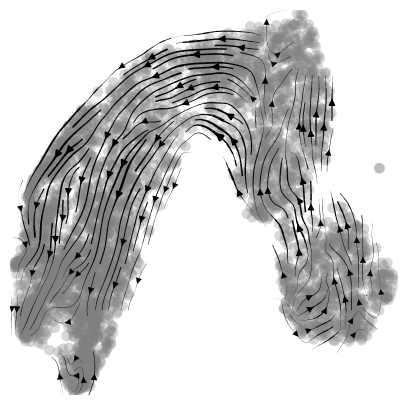

In [24]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [25]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

print('features by chromosome')
extend = 50
ad.var['chr'].value_counts()

features by chromosome


chr
chr2     530
chr5     490
chr1     485
chr11    475
chr4     457
chr7     434
chr6     430
chr3     406
chr8     388
chr9     385
chr13    349
chr10    343
chr12    304
chr14    295
chr15    279
chr17    278
chr16    270
chr18    259
chr19    180
chrX     161
chrY       2
Name: count, dtype: int64

In [26]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [27]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/miniconda3/envs/mubind/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmppksx2yf8
genome mm10 True
annotations/mm10/genome/mm10.fa
True annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/miniconda3/envs/mubind/bin/bedtools', 'getfasta', '-fi', 'annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmppksx2yf8', '-fo', '/tmp/tmpzdii187m']
/home/ilibarra/miniconda3/envs/mubind/bin/bedtools getfasta -fi annotations/mm10/genome/mm10.fa -bed /tmp/tmppksx2yf8 -fo /tmp/tmpzdii187m


7200

In [28]:
len(seqs)

7200

In [29]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [30]:
counts.shape

(7200, 4148)

In [31]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [32]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [33]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(7200, 4149)

In [34]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(7200, 4149)

In [35]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [36]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [37]:
# next_data.index

In [38]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [39]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [40]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(7200, 4148)

In [41]:
ad.shape, df.shape

((4148, 7200), (7200, 4148))

In [42]:
ad = ad[:,~zero_counts].copy()


In [43]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(29865600, 3)
4148
batch
0      7200
137    7200
127    7200
128    7200
129    7200
       ... 
69     7200
70     7200
71     7200
72     7200
199    7200
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
CCCGCCCAAGCCCGTCCACAGATCAAACGTGGCGCCCCGCGCGCTAATAGGGTCTTTCAAAAGTATTTACGCAACCGATCCTGCCCGCGTTTCCGGCCGC,1.0,3.0,0
TGCGAGCCACGCCCCTGAGCGATCCCCAACCTAAGCCCCGCCCATCATTCCTCTCTAGGCTCCACCCAGTAGCCGCTTAAACCTTTCGTCTTTTACCTCC,1.0,1.0,0
GGGGCGGTGAGTGGCAGACCTGAGGGCCAATGGATACTAGAAATCGTCCGGCGCGGCGCTGCATGGGGGTGGAGCCTGCGTTTGGGCGGGGCCTGCGTGC,1.0,3.0,0
CGAGGAGGGCAGAGTGACTCCGCGGGTCTCCCGCGGCTCCTTTTCTCCTCCTCCTGCTCAACGTCCACCCACCTCTCCCCACCCCCATCACTTCCCCCGC,1.0,1.0,0
TCCTGAAGGCTCCGTACCTGTCCCCTTCTTCAGATGCTCTGGGTACACCCTCAGCCCCGCCCCCAGCCCTGGTCCTGCAGAGTAGGCACGCCCCTCTAAC,1.0,3.0,0


### Simple motif enrichment

In [44]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [45]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [46]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [47]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [48]:
reduced_groups = pwms

In [49]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)


In [50]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [51]:
len(pwms)

286

In [52]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [53]:
rna_sample.shape, ad.shape

((4148, 14663), (4148, 7200))

In [54]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(4148, 4148)
setting up log dynamic
no err


In [55]:
# model.graph_module.conn_sparse.shape

setting up log dynamic
True
12
order None
0 out of 288...
break


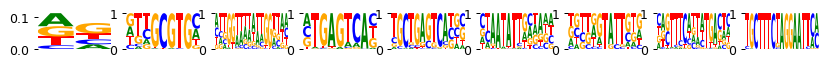

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [29:33<00:00, 118.21s/it]


Current time: 2024-06-11 10:16:26.975959
	Loss: 152.752 , R2: 0.317
	Training time (model/function): (1773.432s / 1773.432s)
		per epoch (model/function): (126.674s/ 126.674s)
		per 1k samples: 17.594s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:00:32<00:00, 242.20s/it]


Current time: 2024-06-11 11:17:04.306771
	Loss: 148.581 , R2: 0.317
	Training time (model/function): (5406.772s / 3633.341s)
		per epoch (model/function): (386.198s/ 259.524s)
		per 1k samples: 36.045s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:00:13<00:00, 240.90s/it]


Current time: 2024-06-11 12:17:22.362187
	Loss: 144.634 , R2: 0.317
	Training time (model/function): (9020.697s / 3613.925s)
		per epoch (model/function): (644.335s/ 258.137s)
		per 1k samples: 35.852s
best loss 144.634
last five r2 values, by sequential filter optimization: ['0.317']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: Poiss

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [50:27<00:00, 201.82s/it]


Current time: 2024-06-11 13:08:01.029759
	Loss: 148.409 , R2: 0.317
	Training time (model/function): (12048.344s / 3027.647s)
		per epoch (model/function): (860.596s/ 216.260s)
		per 1k samples: 30.036s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [42:13<00:00, 168.90s/it]


Current time: 2024-06-11 13:50:22.135571
	Loss: 144.628 , R2: 0.317
	Training time (model/function): (14582.436s / 2534.093s)
		per epoch (model/function): (1041.603s/ 181.007s)
		per 1k samples: 25.140s
best loss 144.626
last five r2 values, by sequential filter optimization: ['0.317', '0.317']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , crite

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [39:23<00:00, 157.58s/it]


Current time: 2024-06-11 14:30:00.655672
	Loss: 148.409 , R2: 0.317
	Training time (model/function): (16946.670s / 2364.233s)
		per epoch (model/function): (1210.476s/ 168.874s)
		per 1k samples: 23.455s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [37:07<00:00, 148.48s/it]


Current time: 2024-06-11 15:07:15.622431
	Loss: 144.627 , R2: 0.317
	Training time (model/function): (19174.565s / 2227.895s)
		per epoch (model/function): (1369.612s/ 159.135s)
		per 1k samples: 22.102s
best loss 144.627
last five r2 values, by sequential filter optimization: ['0.317', '0.317', '0.317']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Ada

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [38:48<00:00, 155.22s/it]


Current time: 2024-06-11 15:46:17.842690
	Loss: 148.409 , R2: 0.317
	Training time (model/function): (21503.380s / 2328.815s)
		per epoch (model/function): (1535.956s/ 166.344s)
		per 1k samples: 23.103s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [39:04<00:00, 156.31s/it]


Current time: 2024-06-11 16:25:30.265608
	Loss: 144.628 , R2: 0.317
	Training time (model/function): (23848.807s / 2345.427s)
		per epoch (model/function): (1703.486s/ 167.530s)
		per 1k samples: 23.268s
best loss 144.627
last five r2 values, by sequential filter optimization: ['0.317', '0.317', '0.317', '0.317']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994660975059181, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 23848.80698442459s
Time per epoch (total): 5.521 s
True
12
order None
0 out of 288...
break


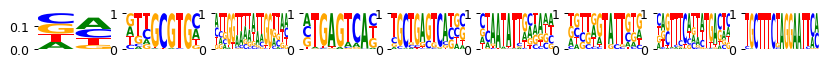

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:57<00:00,  3.85s/it]


Current time: 2024-06-11 16:26:44.971603
	Loss: 152.750 , R2: 0.318
	Training time (model/function): (58.603s / 58.603s)
		per epoch (model/function): (4.186s/ 4.186s)
		per 1k samples: 0.581s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.88s/it]


Current time: 2024-06-11 16:27:50.439595
	Loss: 148.580 , R2: 0.318
	Training time (model/function): (117.346s / 58.744s)
		per epoch (model/function): (8.382s/ 4.196s)
		per 1k samples: 0.583s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:57<00:00,  3.81s/it]


Current time: 2024-06-11 16:28:54.269355
	Loss: 144.635 , R2: 0.318
	Training time (model/function): (175.072s / 57.725s)
		per epoch (model/function): (12.505s/ 4.123s)
		per 1k samples: 0.573s
best loss 144.635
last five r2 values, by sequential filter optimization: ['0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.92s/it]


Current time: 2024-06-11 16:30:06.936966
	Loss: 148.411 , R2: 0.317
	Training time (model/function): (234.404s / 59.332s)
		per epoch (model/function): (16.743s/ 4.238s)
		per 1k samples: 0.589s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.73s/it]


Current time: 2024-06-11 16:31:10.484726
	Loss: 144.627 , R2: 0.318
	Training time (model/function): (290.949s / 56.545s)
		per epoch (model/function): (20.782s/ 4.039s)
		per 1k samples: 0.561s
best loss 144.627
last five r2 values, by sequential filter optimization: ['0.318', '0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: Poi

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.93s/it]


Current time: 2024-06-11 16:32:23.646732
	Loss: 148.421 , R2: 0.317
	Training time (model/function): (350.631s / 59.682s)
		per epoch (model/function): (25.045s/ 4.263s)
		per 1k samples: 0.592s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.69s/it]


Current time: 2024-06-11 16:33:26.897194
	Loss: 144.627 , R2: 0.318
	Training time (model/function): (406.789s / 56.158s)
		per epoch (model/function): (29.056s/ 4.011s)
		per 1k samples: 0.557s
best loss 144.626
last five r2 values, by sequential filter optimization: ['0.318', '0.318', '0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Adam , crite

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.94s/it]


Current time: 2024-06-11 16:34:40.553089
	Loss: 148.433 , R2: 0.317
	Training time (model/function): (466.718s / 59.930s)
		per epoch (model/function): (33.337s/ 4.281s)
		per 1k samples: 0.595s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:54<00:00,  3.63s/it]


Current time: 2024-06-11 16:35:42.487498
	Loss: 144.627 , R2: 0.318
	Training time (model/function): (522.042s / 55.323s)
		per epoch (model/function): (37.289s/ 3.952s)
		per 1k samples: 0.549s
best loss 144.626
last five r2 values, by sequential filter optimization: ['0.318', '0.318', '0.318', '0.317']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9985974893426698, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 522.0417866706848s
Time per epoch (total): 0.121 s


In [57]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 15
n_epochs_kernel = 15
log_each=75
n_unfreeze_kernels=70


for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train,
                                                n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False,
                                                use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

Text(0.5, 0, 'learned etas (per sample)')

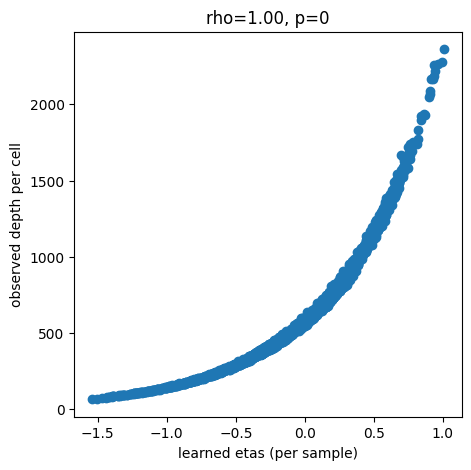

: 

In [60]:
## correlation between etas and observed counts per cell
rcParams['figure.figsize'] = 5, 5
etas = model.get_log_etas()
lib_sizes = train.dataset.rounds.sum(axis=0)
etas.shape, lib_sizes.shape
from scipy.stats import spearmanr

a = etas.detach().cpu().flatten()
b = lib_sizes.flatten()
plt.scatter(a, b)
plt.title('rho=%.2f, p=%.2g' % spearmanr(a, b))
plt.ylabel('observed depth per cell')
plt.xlabel('learned etas (per sample)')

In [59]:
save_output = True

if save_output:
    for use_logdynamic in [False, True]:
        p = 'pancreas_multiome_use_logdynamic_%i_obs%i.pth' % (use_logdynamic, ad.shape[0])
        print(p)
        torch.save(model_by_logdynamic[use_logdynamic], p)

    ad.write('atac_train.h5ad')
    rna_sample.write('rna_sample_train.h5ad')

    import pickle
    pickle.dump(train, open('train_dataloader.pkl', 'wb'))

pancreas_multiome_use_logdynamic_0_obs4148.pth
pancreas_multiome_use_logdynamic_1_obs4148.pth


In [58]:
ls

00_prepare_genre.ipynb
01_1_scatac_pbmc_10x_de_novo.ipynb
01_2_scatac_pbmc_10x_episcanpy_priors.ipynb
01_2_scatac_pbmc_10x_priors.ipynb
02_0_0_prepare_multiome_vel.ipynb
02_1_3_evaluate_graph.ipynb
02_2_1_scatac_multiome_pancreas_priors_train.ipynb
02_2_1_scrna_noack_priors_evaluate.ipynb
02_2_1_scrna_noack_priors_train.ipynb
02_2_2_scatac_multiome_pancreas_priors_evaluate.ipynb
02_2_scrna_multiome_pancreas_priors.ipynb
02_3_scatac_retina.ipynb
03_1_scchipseq_de_novo.ipynb
03_2_schipseq_priors.ipynb
03_3_organoids_priors.ipynb
03_4_gbm_multiome_priors.ipynb
04_0_viz_vector_scvelo.ipynb
annotations@
atac_train.h5ad
data/
noack_2022_sample_train.h5ad
noack_2022_sample_train_obs386.h5ad
noack_2022_sample_train_obs7468.h5ad
noack_2022_use_logdynamic_0_obs386.pth
noack_2022_use_logdynamic_0_obs7468.pth
noack_2022_use_logdynamic_0.pth
noack_2022_use_logdynamic_1_obs386.pth
noack_2022_use_logdynamic_1_obs7468.pth
noack_2022_use_logdynamic_1.pth
noack_et_al_velocity_graph.h5ad*
pancreas_multio